# Level4. 共起行列で文書の分類をする

In [1]:
from datetime import datetime as dt
from pprint import pprint

import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'VL PGothic', 'Noto Sans CJK JP']

/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)
/usr/local/var/pyenv/versions/3.7.4/lib/python3.7/site-packages/pandas/compat/__init__.py:85: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


### データの取得

ターゲットを以下のカテゴリに絞る

In [2]:
target_categories = ['alt.atheism',
#  'comp.graphics',
#  'comp.os.ms-windows.misc',
#  'comp.sys.ibm.pc.hardware',
#  'comp.sys.mac.hardware',
#  'comp.windows.x',
#  'misc.forsale',
#  'rec.autos',
#  'rec.motorcycles',
#  'rec.sport.baseball',
#  'rec.sport.hockey',
#  'sci.crypt',
#  'sci.electronics',
#  'sci.med',
#  'sci.space',
#  'soc.religion.christian',
#  'talk.politics.guns',
#  'talk.politics.mideast',
#  'talk.politics.misc',
 'talk.religion.misc']

データをカテゴリを絞って取得する

In [3]:
from sklearn.datasets import fetch_20newsgroups
newsgroups_train = fetch_20newsgroups(subset='train', categories=target_categories)
newsgroups_test = fetch_20newsgroups(subset='test', categories=target_categories)

In [4]:
print(newsgroups_train.target_names == target_categories)
print(newsgroups_test.target_names == target_categories)

True
True


データが同じカテゴリにしたがっていることが確認できた

### データを確認する

In [5]:
print("train data count:", len(newsgroups_train.data))
print(" test data count:", len(newsgroups_test.data))
print("比率:", len(newsgroups_train.data)/len(newsgroups_test.data))

train data count: 857
 test data count: 570
比率: 1.5035087719298246


学習データのデータ数は11314個。  
訓練データのデータ数は7532個。  
1.5倍くらい。まぁいい感じ？（train:test = 3:2）

In [6]:
idx = 2
print("="*10, "データ", "="*10)
print(newsgroups_train.data[idx])
print("="*10, "カテゴリ", "="*10)
print(newsgroups_train.target[idx], newsgroups_train.target_names[newsgroups_train.target[idx]])

========== データ ==========
From: MANDTBACKA@FINABO.ABO.FI (Mats Andtbacka)
Subject: Re: An Anecdote about Islam
In-Reply-To: jaeger@buphy.bu.edu's message of 5 Apr 93 16:49:14 GMT
Organization: Unorganized Usenet Postings UnInc.
X-News-Reader: VMS NEWS 1.24
Lines: 24

In <114127@bu.edu> jaeger@buphy.bu.edu writes:

[deletia]

> I don't understand the point of this petty sarcasm. It is a basic 
> principle of Islam that if one is born muslim or one says "I testify
> that there is no god but God and Mohammad is a prophet of God" that,
> so long as one does not explicitly reject Islam by word then one _must_
> be considered muslim by all muslims. So the phenomenon you're attempting
> to make into a general rule or psychology is a direct odds with basic
> Islamic principles. If you want to attack Islam you could do better than
> than to argue against something that Islam explicitly contradicts.

      In the deletions somewhere, it mentioned something about chopping
off of hands being a pun

んー、newsgroupってなってるからもっとニュースっぽいのかなと思ったけど、結構難しいな...

> ユーズネット(Usenet)ともいう。電子掲示板に出されたメッセージのこと。各掲示板にはテーマがあり、考えられる限りのトピックに関する何万というニュースグループがある。  
> https://www.weblio.jp/content/newsgroup

なるほど！そもそも俺が考えていたニュースとは違うのかw

## 共起行列で分類してみる

- 全ての文書に入っている単語からcodebookを作成
- codebookにある単語のみから共起行列を作成

In [7]:
from nltk.tokenize import wordpunct_tokenize, sent_tokenize

import nltk
import sklearn.feature_extraction.text as fe_text

In [8]:
stopwords = nltk.corpus.stopwords.words('english')
stopwords.append('.')   # ピリオドを追加。
stopwords.append(',')   # カンマを追加。
stopwords.append('')

In [9]:
def preprocess(text):
    """テキストに対する前処理。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.66より。

    :param text:
    :return:
      courpus(list): id_to_wordのidに基づいたone-hot vector。
      word_to_id(dict): 単語をkeyとして、idを参照する辞書。
      id_to_word(dict): idをkeyとして、単語を参照する辞書。
    """
    text = text.lower()
    text = text.replace('.', ' .')
    text = text.replace('"', '')
    words = text.split(' ')

    word_to_id = {}
    id_to_word = {}
    for word in words:
        if word not in word_to_id:
            new_id = len(word_to_id)
            word_to_id[word] = new_id
            id_to_word[new_id] = word
    corpus = np.array([word_to_id[w] for w in words])
    return corpus, word_to_id, id_to_word

In [10]:
docs_all_str = " ".join(map(lambda x: " ".join(x.split('\n')), newsgroups_train.data))
docs_all_str[:500]

'From: mangoe@cs.umd.edu (Charley Wingate) Subject: Benediktine Metaphysics Lines: 24  Benedikt Rosenau writes, with great authority:  >     IF IT IS CONTRADICTORY IT CANNOT EXIST.  "Contradictory" is a property of language.  If I correct this to         THINGS DEFINED BY CONTRADICTORY LANGUAGE DO NOT EXIST  I will object to definitions as reality.  If you then amend it to        THINGS DESCRIBED BY CONTRADICTORY LANGUAGE DO NOT EXIST  then we\'ve come to something which is plainly false.  Failure'

In [11]:
corpus, word_to_id, id_to_word = preprocess(docs_all_str)
vocab_size = len(word_to_id)
# print(corpus)
# print(word_to_id)
# print(id_to_word)

In [12]:
def create_co_matrix(corpus, vocab_size, window_size=1):
    """共起行列を作成。
    「ゼロから作るDeepLearning2 自然言語処理辺」p.72より。

    :param corpus(str): テキスト文。
    :param vocab_size: 語彙数。
    :param window_size: 共起判定の範囲。
    :return:
    """
    start = dt.now()
    
    corpus_size = len(corpus)
    co_matrix = np.zeros((vocab_size, vocab_size), dtype=np.int32)
    
    for idx, word_id in enumerate(corpus):
        for i in range(1, window_size+1):
            left_idx = idx - i
            right_idx = idx + i
            if left_idx >= 0:
                left_word_id = corpus[left_idx]
                co_matrix[word_id, left_word_id] += 1
            if right_idx < corpus_size:
                right_word_id = corpus[right_idx]
                co_matrix[word_id, right_word_id] += 1
        print("\r{:.4f}% : {}".format((idx+1)/corpus_size, dt.now()-start), end="")
    print("")
    return co_matrix

In [13]:
co_matrix = create_co_matrix(corpus, vocab_size, window_size=2)
df = pd.DataFrame(co_matrix, index=word_to_id.keys(), columns=word_to_id.keys())
df

1.0000% : 0:00:49.802085


,from:,mangoe@cs,.umd,.edu,(charley,wingate),subject:,benediktine,metaphysics,lines:,...,>point?,eveil,counterproductive,bacause,don',failing,agaist,"attacks,",do?!,messgae
from:,0,10,11,24,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
mangoe@cs,10,0,51,36,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.umd,11,51,0,57,26,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.edu,24,36,57,4,26,26,28,0,0,21,...,0,0,0,0,0,0,0,0,0,0
(charley,0,0,26,26,0,26,10,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
failing,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
agaist,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
"attacks,",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
do?!,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
def create_vectors(docs, df_co_matrix):
    start = dt.now()
    features = list(df_co_matrix.columns)
    doclen = len(docs)
    
    vectors = []
    for idx, doc in enumerate(docs):
        doc = doc.lower()
        doc = doc.replace('.', ' .')
        doc = doc.replace('"', '')
        words = doc.split(' ')
        unique_words = filter(lambda x: x in features, set(words))
        
        vector = df_co_matrix[unique_words]
        vector = vector.apply(lambda x: x.sum(), axis=1)
        vectors.append(vector.values)
        print("\r{:.4f}% : {}".format((idx+1)/doclen, dt.now()-start), end="")
    
    print("finished: {}".format(dt.now() - start))
    return np.array(vectors)

In [15]:
vectors_train = create_vectors(newsgroups_train.data, df)

1.0000% : 0:43:04.166264finished: 0:43:04.166380


In [16]:
print("newsgroup: ", len(newsgroups_train.data))
print("train vectors: ", len(vectors_train))

newsgroup:  857
train vectors:  857


In [17]:
vectors_train

array([[1216,  131,  181, ...,    1,    1,    3],
       [1235,   61,   96, ...,    1,    3,    3],
       [1248,   83,  128, ...,    1,    1,    3],
       ...,
       [1359,   81,  137, ...,    1,    2,    3],
       [1284,   70,   92, ...,    0,    1,    2],
       [1232,   81,  137, ...,    4,    3,    4]])

テストデータも同様に処理を行う

In [18]:
vectors_test = create_vectors(newsgroups_test.data, df)

1.0000% : 0:27:56.922663finished: 0:27:56.922779


#### 作成した文書ベクトルを学習させ、分類器を作成する

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix

In [20]:
train_X = vectors_train # 特徴ベクトル
train_Y = newsgroups_train.target # 目的変数
test_X = vectors_test
test_Y = newsgroups_test.target

学習

In [21]:
clf = MultinomialNB(alpha=.01)
clf.fit(train_X, train_Y)

MultinomialNB(alpha=0.01, class_prior=None, fit_prior=True)

推論

In [22]:
pred_Y = clf.predict(test_X)
pred_Y

array([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1,

In [23]:
accuracy_score(test_Y, pred_Y)

0.5719298245614035

In [24]:
acc = []
for idx in range(0, len(target_categories)):
    vec = confusion_matrix(test_Y, pred_Y)[idx]
    acc.append(vec[idx]/sum(vec))

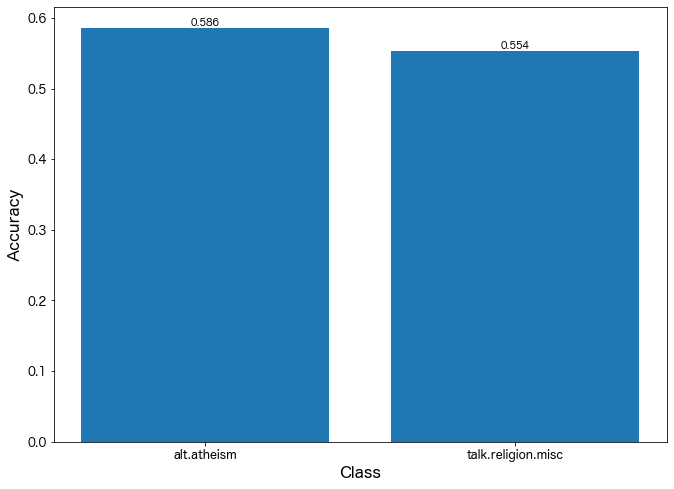

In [25]:
plt.figure(figsize=(11,8))
plt.bar(range(0,len(target_categories)), acc, tick_label=target_categories)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Class", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)

for x, y in zip(range(0,20), acc):
    plt.text(x, y, f"{y:.3f}", ha='center', va='bottom')

plt.show()

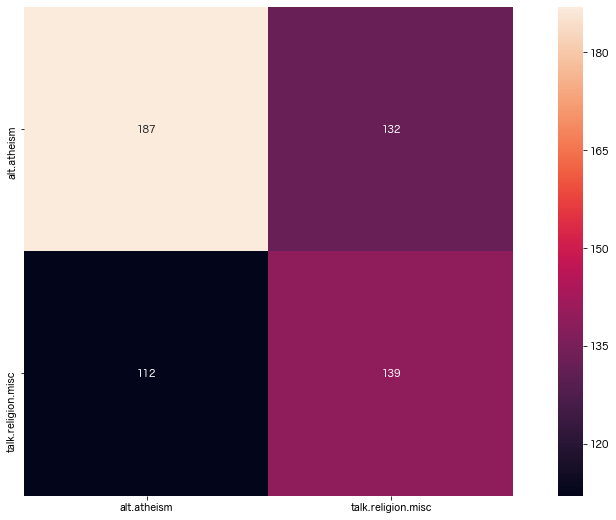

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
sns.heatmap(confusion_matrix(test_Y, pred_Y),
            xticklabels=target_categories,
            yticklabels=target_categories,
            annot=True, fmt='d', square=True, ax=ax)
ax.set_ylim(len(target_categories), 0)
plt.show()